# Python API's
## John M. Warlop
## UCSD Bootcamp Spring 2018
## Due 3/31/18

In [1]:
# Dependencies
import codecs
import openweather as ow
import matplotlib.pyplot as plt
import csv
import pickle
import pandas as pd
import random
import json
import requests
import logging
import time

WAIT_TIME = 1.2
SAMPLE_SIZE  = 20   #s/b 20 for release
SAMPLE_SIZE2 = 500  #s/b 500 for release
raw_fpath = '../raw_data/worldcitiespop.csv'
pickle_fpath = '../raw_data/cities_sorted_by_lat.pkl'
s_fname = 'api_keys'
api_keys = {}
with open(s_fname) as f:
    api_keys = json.load(f)

skip_load = True #Set false to reload raw file
# Config Logger
LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
logging.basicConfig(filename="r_log.log",level=logging.INFO,format=LOG_FORMAT,filemode='w')
logger = logging.getLogger()
# 
def file_kosher(reader):
    fcount = 0
    rcount = 0 
    for row in reader:
        if fcount == 0: #header row
            fcount = len(row) #all rows should have this number of fields
        if fcount == 0 or len(row) != fcount:
            return(0)
        rcount += 1
    return(rcount)

def lat_xover(lat_l):
    c = 0
    for e in lat_l:
        if e[5] > 0:
            return c
        c += 1
    return(0)

def load_pickle(logger,ppath):
    logger.info("Opening pickle file {}".format)
    pickle_in = open(pickle_fpath,"rb")
    sorted_by_lat = pickle.load(pickle_in)
    col = ['CC','City','City2','U','U2','Lat','Lon']
    df = pd.DataFrame(sorted_by_lat,columns=col)
    pickle_in.close()
    logger.info("Pickle file loaded")
    return( (sorted_by_lat, df))

def create_hemisphere_dataframe(df,degree_bins,dict_of_df,logger,hemisphere):
    for idx, lat in enumerate(degree_bins): 
        if idx == len(degree_bins)-1:break 
        logger.debug("Degree bin({}) is: {} to {}".\
                format(hemisphere,degree_bins[idx],degree_bins[idx+1]))
        if hemisphere.find('outh') >= 1: #South
            criteria1 = df['Lat'] <  degree_bins[idx]
            criteria2 = df['Lat'] >= degree_bins[idx+1]
        else: #North
            criteria1 = df['Lat'] >  degree_bins[idx]
            criteria2 = df['Lat'] <= degree_bins[idx+1]
        dict_of_df[idx] = df[criteria1 & criteria2]
        logger.debug("dict_of_df[{}] size of df is: {}".\
                   format(idx,dict_of_df[idx].size))
        
def request_weather_and_populate_tups(api_keys,list_of_tuples,dict_of_df,logger,hemisphere):
    logger.info("Fn: request_weather_and_populate_tups")
    logger.debug("dict_of_df size is: {}, sample size is: {}".\
        format(len(dict_of_df),SAMPLE_SIZE))
    for idx in range(len(dict_of_df)):
        logger.debug("increment #{} of dict_of_df size {}".format(idx,len(dict_of_df)))
        logger.debug("dict_of_df[{}] df size is: {}".format(idx,dict_of_df[idx].size))
        df_25 = dict_of_df[idx].sample(SAMPLE_SIZE,replace=True)
        logger.info("df_25 size is: {}".format(df_25.size))
        rcount = 0
        for row in df_25.itertuples():
            city,lat_,lon_ = getattr(row,'City'),getattr(row,'Lat'),getattr(row,'Lon')
            url = "http://api.openweathermap.org/data/2.5/weather?lat="+\
                str(lat_)+"&lon="+str(lon_)+"&appid="+api_keys['OpenWeather']
            r = requests.get(url).json()
            tmp,hum,cl,wsp,c_id = (r["main"]["temp"]-273)*(9/5)+32.0,r["main"]["humidity"],\
                                    r["clouds"]["all"],r["wind"]["speed"],r["id"]
            logger.debug("City {}: {}, {}, {}, {}, {}, {}, {}".\
                    format(city,lat_,lon_,tmp,hum,cl,wsp,c_id))
            logger.info("Processing city {} set {} of row {}".format(city,idx,rcount))
            logger.info("{}".format(url))
            time.sleep(WAIT_TIME)
            tups.append((city, lat_, lon_,tmp,hum,cl,wsp,c_id))
            rcount += 1
    logger.info("{} hemisphere is complete".format(hemisphere))


def make_scatter_plots(logger):
    titles = ['Lat(deg) vs Temp(F)','Lat(deg) vs % Humidity','Latitude(deg) vs Wind Speed',\
              'Latitude(deg) vs % Cloudiness','Lon(deg) vs Lat(deg)']
    fnames = ['lat_temp.png','lat_humidity.png','lat_wind.png','lat_clouds.png','lon_lat.png']
    xnames = ['lat','lat','lat','lat','lon']
    ynames = ['temp','humidity','wind','clouds','lat']
    for idx, name in enumerate(titles):
        weather500_df.plot.scatter(x=xnames[idx],y=ynames[idx])
        fig = plt.gcf()
        plt.title(name)
        plt.show()
        fig.savefig(fnames[idx])
        logger.debug("Fn: make_scatter_plots: {} written".format(fnames[idx]))

## Load CSV

In [2]:
# Load CSV
if not skip_load:
    error = False
    logger.info("Open pickle: {}".format(raw_fpath))
    with open(raw_fpath,"r",encoding="ISO-8859-1") as f:
        reader = csv.reader(f)
        nrows = file_kosher(reader)
        if not nrows:
            error = True
        reader = f.seek(0) #put back @ head
        c = 0
        reader = csv.reader(f)
        file_l = []
        next(reader,None)
        for row in reader:
            row[5] = float(row[5])
            row[6] = float(row[6])
            trow = tuple(row)
            file_l.append(trow)
            c += 1
        logger.debug("Raw file loaded, sorting list")
        ss = sorted(file_l,key = lambda x: (x[5],x[6]))
        pckl_out = open(pickle_fpath,"wb")
        logger.info("Dumping sorted list to pickle name: {}".format(pickle_fpath))
        pickle.dump(ss,pckl_out)
        pckl_out.close()
        del(ss)

## Load Pickled File

In [3]:
# Open pickled file(sorted by latitutde)
(sorted_by_lat, df) = load_pickle(logger,pickle_fpath)
xover_idx,min_lat,max_lat = lat_xover(sorted_by_lat),sorted_by_lat[0][5],sorted_by_lat[-1][5]
logger.debug("xover idx: {}, min_lat: {}, max_lat: {} ".format(xover_idx,min_lat,max_lat))
logger.debug("First record: {}".format(sorted_by_lat[0]))
logger.debug("Last record: {}".format(sorted_by_lat[-1]))
logger.debug("Length of sorted list: {}".format(len(sorted_by_lat)))
# Get Southern Hemisphere degree increments
south_deg_bins = [i*abs(min_lat/20.0)*-1.0 for i in range(0,21)]
logger.debug("South deg bin: {}".format(south_deg_bins))
logger.debug("South deg bin size: {}".format(len(south_deg_bins)))


## Do Southern Hemisphere

In [4]:
south_df={}
create_hemisphere_dataframe(df,south_deg_bins,south_df,logger,"South")


## Get Weather from API @ OpenWeather(Southern Hemisphere)

In [5]:
tups = []
request_weather_and_populate_tups(api_keys,tups,south_df,logger,"Southern")

In [6]:
# Get Northern Hemisphere degree increments
north_deg_bins = [i*abs(max_lat/20.0) for i in range(0,21)]
logger.debug("North deg bin: {}".format(north_deg_bins))
logger.debug("North deg bin size: {}".format(len(north_deg_bins)))        
north_df={}
create_hemisphere_dataframe(df,north_deg_bins,north_df,logger,"North")


## Get Weather from API @ OpenWeather(Northern Hemisphere)

In [7]:
logger.debug("north_df[0] size is: ".format(north_df[0].size))
request_weather_and_populate_tups(api_keys,tups,north_df,logger,"Northern")

## Save weather to dataframe and pickle it

In [8]:
cols = ['City','lat','lon','temp','humidity','clouds','wind','c_id']
weather_df = pd.DataFrame(tups,columns=cols)
weather_df.to_pickle('../raw_data/weather_df.pkl')
logger.info("End: Build Analysis Dataframe")

## Randomly choose 500 weather stations, store in df and pickle

In [ ]:
logger.info("Begin: Plot & Save Images")
import arff
weather_df = pd.read_pickle('../raw_data/weather_df.pkl')
if weather_df.size >= SAMPLE_SIZE2:
    weather500_df = weather_df.sample(SAMPLE_SIZE2,replace=True)
    weather500_df.to_pickle('../raw_data/weather500_df.pkl')
    weather500_df.to_csv("weather500_df.csv")
else:
    logger.info("Unable to sample of size {}".format(SAMPLE_SIZE2))
#
logger.debug("Size of weather500_df is: {}".format(weather500_df.size))

## Make Scatter Plots

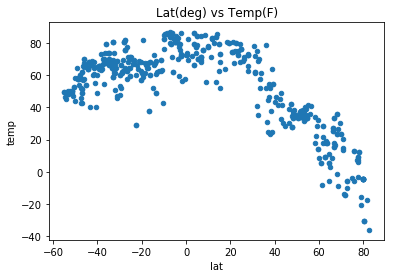

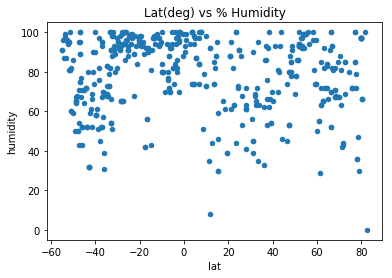

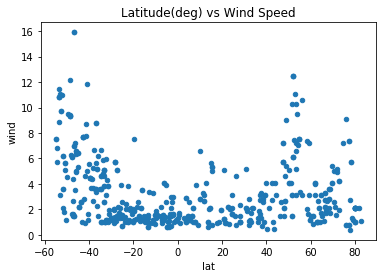

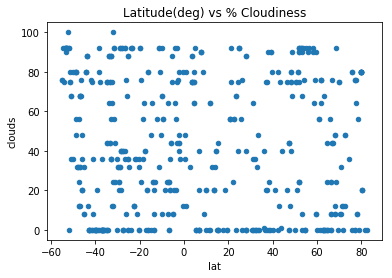

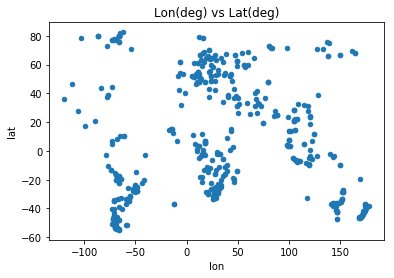

In [9]:
make_scatter_plots(logger)
#

In [10]:
#Clean Log File
import re
with open("r_log.log","r") as f:
    data = f.read()
f.close()
ndata = re.sub(r'appid=\S+\s','appid=**hidden** ',data)
with open("r_log_clean.log","w") as f2:
    f2.write(ndata)
f2.close()